# Predicting Cryptocurrency Stock Prices Using Facebook's Prophet

Author: **Marcin Sikorski**<br>
Date: December, 2021

Crytpocurrencies are lately very trendy and a big subject to investment. Stock market prediction is the act of trying to determine the future value of an other financial instrument or company stock traded on a financial exchange. Time series predicting is one of most demanding object in machine learning on today's market.

**Understanding Cryptocurrencies**<br>
A cryptocurrency is a digital or binary collection of data that is secured by cryptography, which makes it nearly impossible to counterfeit or double spend. Many cryptocurrencies are decentralized networks based on blockchain technology. A defining feature of cryptocurrencies is that they are generally not issued by any central authority, rendering them theoretically immune to government interference or manipulation. This type of technology will disrupt many industries, like finance and law. This type of payment holds the promise of making it easier to transfer funds directly between two parties, without the need for a trusted third party like a bank or credit card company. It also means there is high anonimity and no tracking.

Unfortunately, cryptocurrencies are not perfect. The nature of cryptocurrency transactions makes them well suited for illegal activities, such as money laundering and tax evasion. They are also popular as payment in the so called dark web. Some currencies are relatively poor too choose for conducting illegal business online, since the forensic analysis of some blockchains have helped authorities arrest and prosecute criminals.

**Problem Description**<br>
We want to know future stock data for Ethereum cryptocurrency. For this task we will discover how to build a predictive model using <code>Prophet</code> library and forecast future prices 60 days ahead.

**Report Content:**<br>
1. Importing Packages and Stock Data<br>
2. Plotting Time Series<br>
3. Introducing the Prophet Model<br>
4. Developing the Predictive Model and Visualizing Results<br>
    4.1 Analyzing Seasonality and Individual Components<br>
    4.2 Trend Changepoints<br>
5. Accuracy Metrics and Measure Performance of Fitted Model
6. Extrapolating Future Stock Data<br>
7. Summary and Final Thoughts

[1]:https://www.investopedia.com/terms/c/cryptocurrency.asp

### 1. Importing Packages and Stock Data

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from alpha_vantage.cryptocurrencies import CryptoCurrencies

To get stock data for this repository, we will use Alpha Vantage. This API supplies us with real time stock prices in tabular form in daily resolution. I keep my API key in *txt* file for privacy.

In [3]:
# read API key from text file
with open('api_key.txt') as f:
    api_key = f.readline()

In [4]:
# currency and market symbol
symbol='ETH'
market='PLN'

# API call for Polish market
cc = CryptoCurrencies(key=api_key, output_format='pandas', indexing_type='date')
data, metadata = cc.get_digital_currency_daily(symbol=symbol, market=market)

# display call metadata
metadata

{'1. Information': 'Daily Prices and Volumes for Digital Currency',
 '2. Digital Currency Code': 'ETH',
 '3. Digital Currency Name': 'Ethereum',
 '4. Market Code': 'PLN',
 '5. Market Name': 'Polish Zloty',
 '6. Last Refreshed': '2021-12-29 00:00:00',
 '7. Time Zone': 'UTC'}

In [5]:
# display recent day values
data.head()

,1a. open (PLN),1b. open (USD),2a. high (PLN),2b. high (USD),3a. low (PLN),3b. low (USD),4a. close (PLN),4b. close (USD),5. volume,6. market cap (USD)
date,,,,,,,,,,
2021-12-29,15353.810550,3792.75,15495.618996,3827.78,14964.778530,3696.65,15051.207600,3718.00,258948.3029,258948.3029
2021-12-28,16343.474004,4037.22,16343.514486,4037.23,15218.641152,3759.36,15353.810550,3792.75,358064.7163,358064.7163
2021-12-27,16450.144074,4063.57,16708.783572,4127.46,16318.294200,4031.00,16343.514486,4037.23,222202.1383,222202.1383
2021-12-26,16574.788152,4094.36,16617.861000,4105.00,16192.800000,4000.00,16450.103592,4063.56,189309.2550,189309.2550
2021-12-25,16380.434070,4046.35,16751.087262,4137.91,16268.177484,4018.62,16576.690806,4094.83,208126.8805,208126.8805


We are mostly interested in open and close values, so we will rename these columns more suitable.

In [6]:
# rename columns
data = data.rename(columns={'1a. open (PLN)': 'open_pln', '1b. open (USD)': 'open_usd',
                            '4a. close (PLN)': 'close_pln', '4b. close (USD)': 'close_usd'})

In [7]:
# display number of rows and columns
data.shape

(1000, 10)

In [8]:
# search for NaN values in columns
data.isnull().sum()

open_pln               0
open_usd               0
2a. high (PLN)         0
2b. high (USD)         0
3a. low (PLN)          0
3b. low (USD)          0
close_pln              0
close_usd              0
5. volume              0
6. market cap (USD)    0
dtype: int64

**Foreign Exchange (FX)**<br>
Additionally, we will display information about foreign exchange. The foreign exchange endpoint has no metadata.

In [9]:
from alpha_vantage.foreignexchange import ForeignExchange

fx = ForeignExchange(key=api_key, output_format='json')
# this API call has no metadata
exchange, _ = fx.get_currency_exchange_rate(from_currency=symbol, to_currency=market)

# display foreign exchange
exchange

{'1. From_Currency Code': 'ETH',
 '2. From_Currency Name': 'Ethereum',
 '3. To_Currency Code': 'PLN',
 '4. To_Currency Name': 'Polish Zloty',
 '5. Exchange Rate': '14659.34213800',
 '6. Last Refreshed': '2021-12-30 00:03:31',
 '7. Time Zone': 'UTC',
 '8. Bid Price': '14659.34213800',
 '9. Ask Price': '14659.38260000'}

### 2. Plotting Time Series

Our dataset is complete and ready for further actions. Let's visualize stock prices.

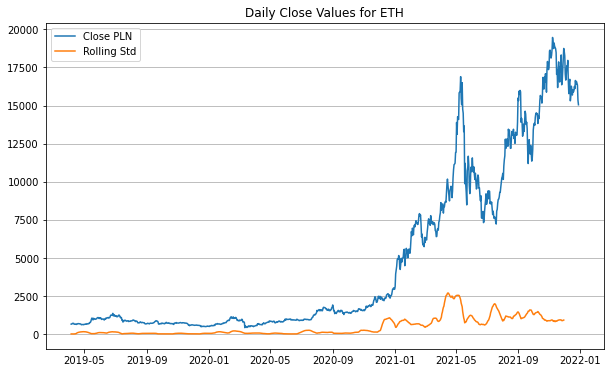

In [10]:
# time series for Ethereum
time_series = data['close_pln'].rolling(window=30).std()

plt.figure(figsize=(10,6))
plt.plot(data['close_pln'], label='Close PLN')
plt.plot(time_series, label='Rolling Std')
plt.title('Daily Close Values for {}'.format(symbol))
plt.grid(axis='y')
plt.legend()
plt.show()

In this chart we can easily spot drastic increase of close prices from 2021. The ongoing pandemic has affected every financial product, whether it is the stock market, commodities market or even the cryptocurrency market. Despite such extremity and economic meltdowns, cryptocurrencies overall have proved to be remarkably resilient. We can believe the rapid increase in accessibility of global high speed internet and digitization has created a ripe environment for digital currency. COVID-19 most likely inclined people towards using digital payment modes than ever.<br>
We will check and plot daily differences of stock prices in precentage - open and close. A histogram will be the best option to demonstrate them.

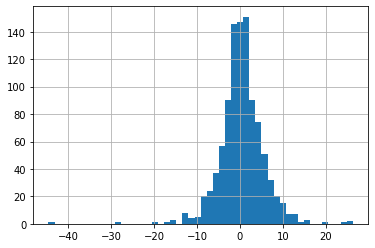

In [11]:
# new column with changes in percent
data['diff_perc'] = ((data['close_pln'] * 100) / data['open_pln']) - 100

# plot histogram
data['diff_perc'].hist(bins=50)

Most changes are between 0 and 5% (negative and positive).<br>
Unlike long term investing, trading often has a short term focus. Let's check if there is a best day of the week to buy stocks and vice versa the best day to sell them.

In [12]:
# new column with dates from index
data['dates'] = pd.to_datetime(data.index)
# new column with days of week
data['weekday'] = data['dates'].dt.day_name()

# display new columns
data[['dates', 'weekday']].tail()

,dates,weekday
date,,
2019-04-09,2019-04-09,Tuesday
2019-04-08,2019-04-08,Monday
2019-04-07,2019-04-07,Sunday
2019-04-06,2019-04-06,Saturday
2019-04-05,2019-04-05,Friday


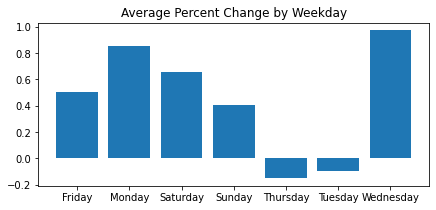

In [13]:
# pivot table with avg values
pivot_tab = pd.pivot_table(data, index=['weekday'], values=['diff_perc'], aggfunc='mean')
# new column
pivot_tab['weekday'] = pivot_tab.index

# bar plot
plt.figure(figsize=(7,3))
plt.bar(x=pivot_tab['weekday'], height=pivot_tab['diff_perc'])
plt.title('Average Percent Change by Weekday')
plt.show()

It's surprising that all weekdays are trading days for cryptocurrencies. The stock market is closed on weekends, but it is not not the case for digital currencies. This is another property due to the fact that it is resistant to government interference. Tuesday may be the best day of the week to buy Ethereum stocks and Wednesday may be the best day for short selling them.

### 3. Introducing the Prophet Model

<code>Prophet</code> is an open source time series forecasting package designed and used by Facebook's data science research team for ease of use without any expert knowledge in statistics or time series forecasting. It is recommended for time series that have strong seasonal effects and several seasons of historical data. The underlying algorithm is a generalized additive model where non linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It is great for stationary data. <code>Prophet</code> also does well with outliers and is robust to missing data and shifts in the trend.<br>
The mathematical core equation behind the model is defined as:

\begin{aligned}
y(t) = g(t) + s(t) + h(t) + ε(t)
\end{aligned}

* where, g(t) represents growth or trend ;
* s(t) represents periodic changes or seasonality (weekly, monthly, yearly);
* h(t) represents the effects of holidays (special days that impact businesses);
* &epsilon;(t) is the error term.

In [14]:
# extracting close prices
df = data[['close_pln']]
df.reset_index(inplace=True)

# Prophet requires specific column names: ds and y
df.columns = ['ds', 'y']
df.head()

,ds,y
0,2021-12-29,15051.207600
1,2021-12-28,15353.810550
2,2021-12-27,16343.514486
3,2021-12-26,16450.103592
4,2021-12-25,16576.690806


We can tune our model to make it more accurate by adding regressors, noises and other factors. For instance, we can assume that weather tempature has an impact on grill or bicycle sales. Another example can be vacation schedules or school breaks which repeat each year. Custom regressors can be added to the linear part of the model using the <code>add_regressor</code> method. We don't have any knowledge about external effects for Ethereum, so we will fit our model without them. With <code>add_seasonality</code> function, we can add other custom season patterns.

<code>Prophet</code> also allows us to model holidays and special events (Black Friday, sport events). We know *a priori* that holidays affect stock market -  mostly public holidays are followed by significant post holiday price drifts. We will pass Polish holidays in a dataframe and implement it for modelling.

In [15]:
import holidays

# list of years ranged in time series
years = [2019, 2020, 2021, 2022]

# display holidays
for date in holidays.Poland(years=years).items():
    print(str(date[0]) + ' ' + str(date[1]))

2019-01-01 Nowy Rok
2019-01-06 Święto Trzech Króli
2019-04-21 Niedziela Wielkanocna
2019-04-22 Poniedziałek Wielkanocny
2019-05-01 Święto Państwowe
2019-05-03 Święto Narodowe Trzeciego Maja
2019-06-09 Zielone Świątki
2019-06-20 Dzień Bożego Ciała
2019-08-15 Wniebowzięcie Najświętszej Marii Panny
2019-11-01 Uroczystość Wszystkich świętych
2019-11-11 Narodowe Święto Niepodległości
2019-12-25 Boże Narodzenie (pierwszy dzień)
2019-12-26 Boże Narodzenie (drugi dzień)
2020-01-01 Nowy Rok
2020-01-06 Święto Trzech Króli
2020-04-12 Niedziela Wielkanocna
2020-04-13 Poniedziałek Wielkanocny
2020-05-01 Święto Państwowe
2020-05-03 Święto Narodowe Trzeciego Maja
2020-05-31 Zielone Świątki
2020-06-11 Dzień Bożego Ciała
2020-08-15 Wniebowzięcie Najświętszej Marii Panny
2020-11-01 Uroczystość Wszystkich świętych
2020-11-11 Narodowe Święto Niepodległości
2020-12-25 Boże Narodzenie (pierwszy dzień)
2020-12-26 Boże Narodzenie (drugi dzień)
2021-01-01 Nowy Rok
2021-01-06 Święto Trzech Króli
2021-04-04 Nied

In [16]:
# create dataframe with Polish holidays
dates = []
names = []

for date in holidays.Poland(years=years).items():
    dates.append(str(date[0]))
    names.append(str(date[1]))

# columns must be named: ds and holiday
pl_holidays = pd.DataFrame(list(zip(dates, names)), columns =['ds', 'holiday'])
pl_holidays.head()

,ds,holiday
0,2019-01-01,Nowy Rok
1,2019-01-06,Święto Trzech Króli
2,2019-04-21,Niedziela Wielkanocna
3,2019-04-22,Poniedziałek Wielkanocny
4,2019-05-01,Święto Państwowe


### 4. Developing the Predictive Model and Visualizing Results

After creating dataframe with holidays, it's time to implement our model and define it's arguments. Stock price behavior is the classic example of a stochastic model. Business time series often have multi period seasonality as a result of the human behaviors they represent. Our model is more likely multiplicative due to the fact that seasonal pattern increases or decreases as the data values increase or decrease.

From previous plots we can accept our examined time series has yearly and monthly seasonality. Monthly patterns will be added as custom. The default Fourier order for yearly seasonality is 10. Since it is hard to find any other data patterns, we will leave reamaining seasonalities as default.

We will leave the <code>growth</code> argument undefined - there is no linear or logistic growth.<br>
The model will output a predicted value as well as the lower and upper bounds of the uncertainty (or confidence) interval. We will increase the threshold in order to increase accuracy of the interval. The uncertainty interval width will be set to 0.95, meaning that the uncertainty interval will cover only 95% of the samples.

In [17]:
from fbprophet import Prophet

# passing model parameters
model = Prophet(interval_width=0.95,
                seasonality_mode='multiplicative',
                yearly_seasonality=True,
                #weekly_seasonality='auto',
                #daily_seasonality='auto',
                #growth='logistic',
                #mcmc_samples=0,
                #stan_backend=0,
                holidays=pl_holidays)

# add monthly seasonality
model.add_seasonality(name='custom_monthly', period=30.5, fourier_order=10)

Unlike other machine learning methods, <code>Prophet</code> doesn't require splitting data into train and test sets. Instead, it uses all historical observations and then ask the model to predict future values.

In [18]:
# fitting the model
model.fit(df)
# display implemented components
model.component_modes

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


{'additive': ['additive_terms', 'extra_regressors_additive'],
 'multiplicative': ['custom_monthly',
  'yearly',
  'weekly',
  'Nowy Rok',
  'Święto Trzech Króli',
  'Niedziela Wielkanocna',
  'Poniedziałek Wielkanocny',
  'Święto Państwowe',
  'Święto Narodowe Trzeciego Maja',
  'Zielone Świątki',
  'Dzień Bożego Ciała',
  'Wniebowzięcie Najświętszej Marii Panny',
  'Uroczystość Wszystkich świętych',
  'Narodowe Święto Niepodległości',
  'Boże Narodzenie (pierwszy dzień)',
  'Boże Narodzenie (drugi dzień)',
  'multiplicative_terms',
  'extra_regressors_multiplicative',
  'holidays']}

First, we will make a prediction on historical data (an in sample forecast). Reviewing the results can give insight into how good the model is. Ideally, the new computed data should overlay historical data.<br>
The result of the <code>predict</code> function is a very detailed dataset. We are mostly interested in columns: <code>ds</code> (forecasted date) and <code>yhat</code> (forecasted value). Other columns contain information about: trend, lower and upper bounds, seasonality terms, e.t.c.

In [19]:
# make an in-sample forecast
# include_history=False - does not save historical data in dataframe
in_sample = model.make_future_dataframe(periods=0, freq='D', include_history=True)
pred = model.predict(in_sample)

In [20]:
# merge actual and forecast data
act_for = df.merge(right=pred, how='left', on='ds')
act_for.head()

,ds,y,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Boże Narodzenie (drugi dzień),Boże Narodzenie (drugi dzień)_lower,Boże Narodzenie (drugi dzień)_upper,Boże Narodzenie (pierwszy dzień),Boże Narodzenie (pierwszy dzień)_lower,Boże Narodzenie (pierwszy dzień)_upper,Dzień Bożego Ciała,Dzień Bożego Ciała_lower,Dzień Bożego Ciała_upper,Narodowe Święto Niepodległości,Narodowe Święto Niepodległości_lower,Narodowe Święto Niepodległości_upper,Niedziela Wielkanocna,Niedziela Wielkanocna_lower,Niedziela Wielkanocna_upper,Nowy Rok,Nowy Rok_lower,Nowy Rok_upper,Poniedziałek Wielkanocny,Poniedziałek Wielkanocny_lower,Poniedziałek Wielkanocny_upper,Uroczystość Wszystkich świętych,Uroczystość Wszystkich świętych_lower,Uroczystość Wszystkich świętych_upper,Wniebowzięcie Najświętszej Marii Panny,Wniebowzięcie Najświętszej Marii Panny_lower,Wniebowzięcie Najświętszej Marii Panny_upper,Zielone Świątki,Zielone Świątki_lower,Zielone Świątki_upper,custom_monthly,custom_monthly_lower,custom_monthly_upper,holidays,holidays_lower,holidays_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,Święto Narodowe Trzeciego Maja,Święto Narodowe Trzeciego Maja_lower,Święto Narodowe Trzeciego Maja_upper,Święto Państwowe,Święto Państwowe_lower,Święto Państwowe_upper,Święto Trzech Króli,Święto Trzech Króli_lower,Święto Trzech Króli_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2021-12-29,15051.207600,19531.586978,16169.370273,17834.500552,19531.586978,19531.586978,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.056758,-0.056758,-0.056758,0.000000,0.000000,0.000000,-0.129993,-0.129993,-0.129993,0.001731,0.001731,0.001731,-0.074966,-0.074966,-0.074966,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16992.620817
1,2021-12-28,15353.810550,19487.911894,15331.973843,16897.387436,19487.911894,19487.911894,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.076639,-0.076639,-0.076639,0.000000,0.000000,0.000000,-0.172317,-0.172317,-0.172317,-0.006379,-0.006379,-0.006379,-0.089299,-0.089299,-0.089299,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16129.821089
2,2021-12-27,16343.514486,19444.236810,15351.965882,17014.347976,19444.236810,19444.236810,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.061358,-0.061358,-0.061358,0.000000,0.000000,0.000000,-0.164890,-0.164890,-0.164890,-0.000505,-0.000505,-0.000505,-0.103028,-0.103028,-0.103028,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16238.070074
3,2021-12-26,16450.103592,19400.561725,15492.035802,17208.023129,19400.561725,19400.561725,0.005959,0.005959,0.005959,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.051029,-0.051029,-0.051029,0.005959,0.005959,0.005959,-0.155447,-0.155447,-0.155447,0.005574,0.005574,0.005574,-0.115951,-0.115951,-0.115951,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16384.802731
4,2021-12-25,16576.690806,19356.886641,15688.880247,17308.960887,19356.886641,19356.886641,0.000000,0.000000,0.000000,0.034685,0.034685,0.034685,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.055646,-0.055646,-0.055646,0.034685,0.034685,0.034685,-0.147768,-0.147768,-0.147768,0.001075,0.001075,0.001075,-0.127882,-0.127882,-0.127882,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16496.565217


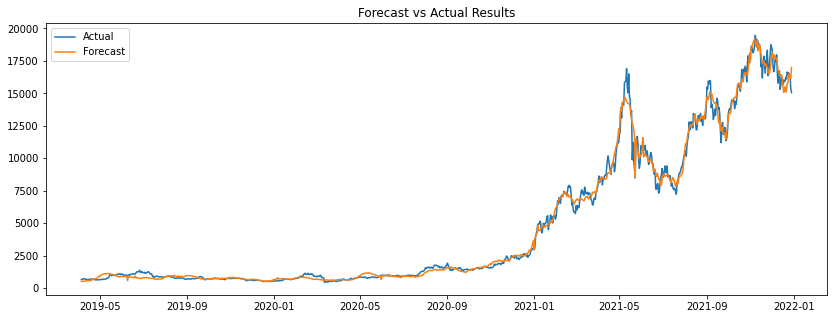

In [21]:
# plot comparing the actual vs. predicted values
plt.figure(figsize=(14,5))
plt.plot(act_for['ds'], act_for['y'], label='Actual')
plt.plot(act_for['ds'], act_for['yhat'], label='Forecast')
plt.title('Forecast vs Actual Results')
plt.legend()
plt.show()

We can now clearly see that the current model was able to fit the underlying trend pretty well and gave a good fit, but still it is unable to capture the sudden peaks and jumps in the time series. These jumps are basically caused by the external regressors which <code>Prophet</code> is unable to detect by default. We will see how to model external factors.

#### 4.1 Analyzing Seasonality and Individual Components

Below, we will plot all available seasonalities in our developed model. We will also plot individual components to check there impact on the computed results.

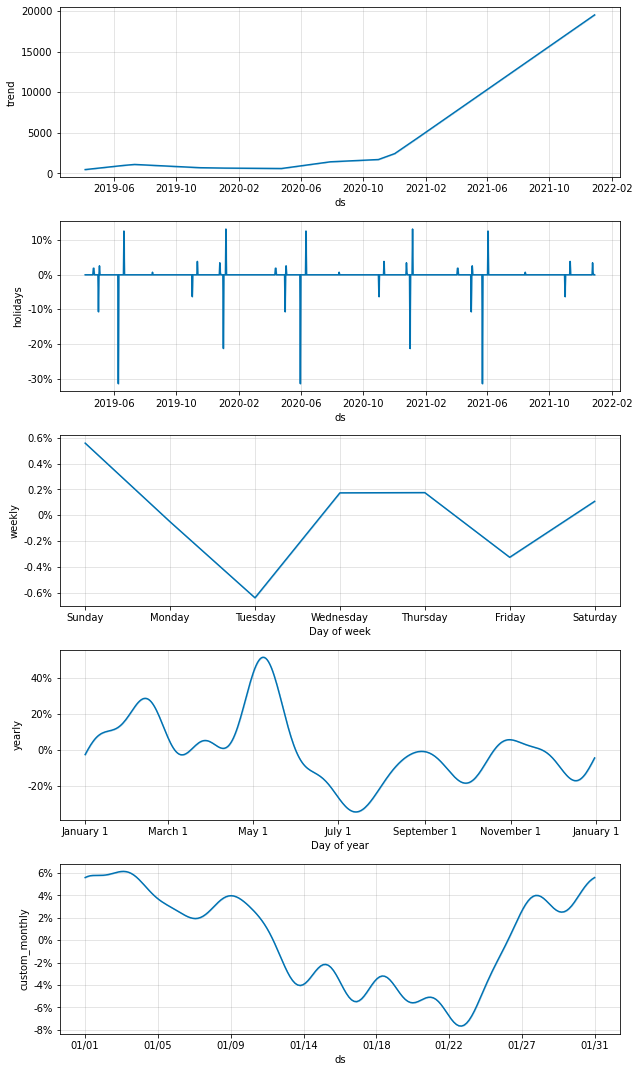

In [22]:
# plot available model forecast components
fig1 = model.plot_components(fcst=pred)

Again, from weekly seasonality we can observe Wednesday is the most active day for trading digital currencies. Weekends in general also seem to be more active.<br>
The peak time is in the first half of May. Summer break is the least active selling time of the year, which should come as no surprise.<br>
We will check individual seasonality for two holidays celebrated in Poland.

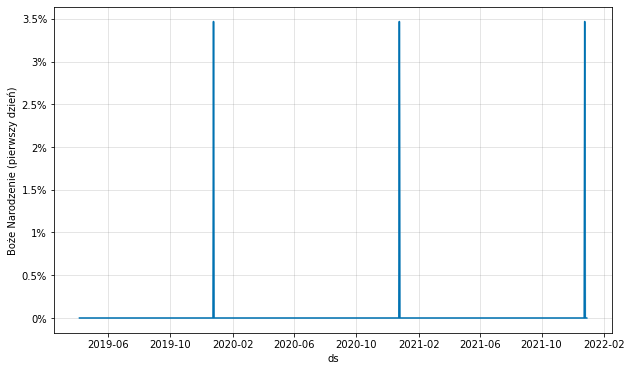

In [23]:
# plot Christmas Day (first day) component
from fbprophet.plot import plot_forecast_component
fig2 = plot_forecast_component(model, pred, 'Boże Narodzenie (pierwszy dzień)')

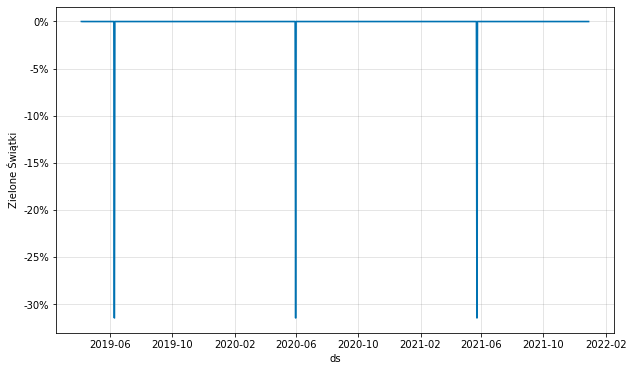

In [24]:
# plot Green Week component
fig3 = plot_forecast_component(model, pred, 'Zielone Świątki')

First day of Christmas seems to have slight impact on Ethereum stock prices.
Green Week on the other hand is characterized by a clearly reduced activity and volatility of investors with -30% sales. Perhaps this holiday is more respected?

#### 4.2 Trend Changepoints

Real time series frequently have abrupt changes in their trajectories. By default, <code>Prophet</code> can automatically detect these changepoints and will allow the trend to adapt appropriately. We will plot these trend changes to get more detailed insight of the data.

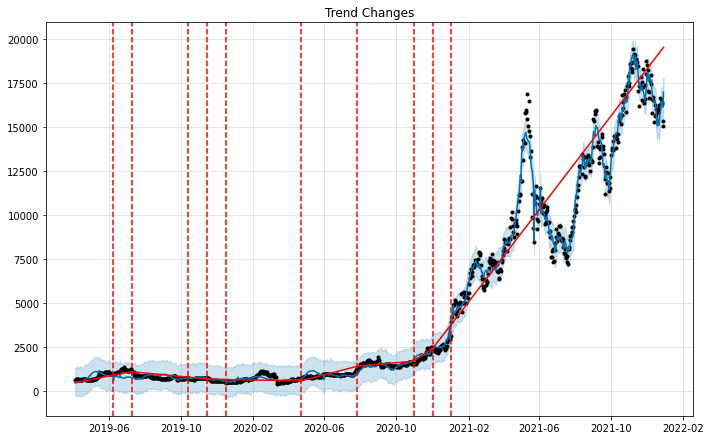

In [25]:
# plot trend changepoints
from fbprophet.plot import add_changepoints_to_plot
fig4 = model.plot(fcst=pred, xlabel=None, ylabel=None)
add_changepoints_to_plot(fig4.gca(), m=model, fcst=pred, cp_color='r', trend=True, cp_linestyle='--')
plt.title('Trend Changes')
plt.show()

In [26]:
# display number of dates with trend changepoints
print(len(model.changepoints))

# display these dates
model.changepoints

25


32    2019-05-07
64    2019-06-08
96    2019-07-10
128   2019-08-11
160   2019-09-12
192   2019-10-14
224   2019-11-15
256   2019-12-17
288   2020-01-18
320   2020-02-19
352   2020-03-22
384   2020-04-23
415   2020-05-24
447   2020-06-25
479   2020-07-27
511   2020-08-28
543   2020-09-29
575   2020-10-31
607   2020-12-02
639   2021-01-03
671   2021-02-04
703   2021-03-08
735   2021-04-09
767   2021-05-11
799   2021-06-12
Name: ds, dtype: datetime64[ns]

### 5. Accuracy Metrics and Measure Performance of Fitted Model

We will develop an objective estimate of our forecast model’s performance. We will plot diagnostics and calculate some basic accuracy metrics.

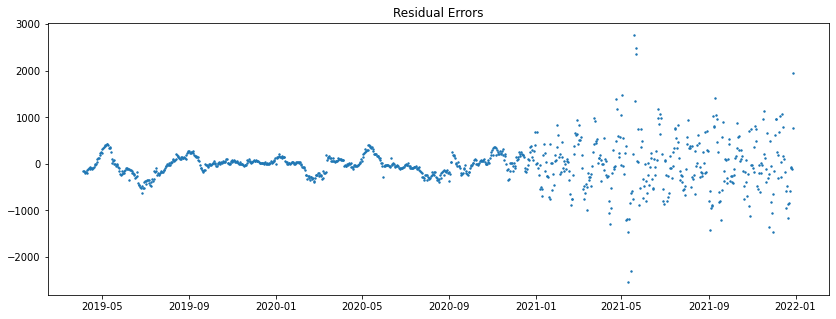

In [27]:
# plot residuals
plt.figure(figsize=(14,5))
plt.scatter(act_for['ds'], act_for['yhat'] - act_for['y'], s=2)
plt.title('Residual Errors')
plt.show()

The residual errors seem to fluctuate around a mean of zero. Residuals later on are exponentially larger due to increasing stock prices. Again, we can observe the model is unable to capture sudden peaks in the time series.

In [28]:
# root mean squared error
from sklearn.metrics import mean_squared_error
rmse = mean_squared_error(act_for['y'], act_for['yhat'], squared=False)
rmse

414.24835894532424

In [29]:
# mean absolute error
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(act_for['y'], act_for['yhat'])
mae

264.8967732710136

In [30]:
# mean absolute percentage error
import numpy as np
mape = np.mean(np.abs(act_for['y'] - act_for['yhat']) / act_for['y']) * 100
mape

10.699078490998945

In [31]:
# correlation
corr = np.corrcoef(act_for['y'], act_for['yhat'])[0,1]
corr

0.9971677876277272

<code>Prophet</code> for forecast error measuring offers cross validation test using historical data. We’ll do this by comparing the predicted values with the actual values. In order to perform this operation we select cut off points in the history of the data and fit the model with data up to that cut off point. Afterwards we compare the actual values to the predicted values. Period is how much data to add to the training data set in every iteration of cross validation, and horizon is how far out it will forecast.

In [32]:
# generating cross validation dataframe
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(model, initial='180 days', period='30 days', horizon='60 days')
df_cv.head()

INFO:fbprophet:Making 26 forecasts with cutoffs between 2019-10-11 00:00:00 and 2021-10-30 00:00:00


  0%|          | 0/26 [00:00<?, ?it/s]

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2019-10-12,796.821266,713.068560,875.875323,727.380576,2019-10-11
1,2019-10-13,810.104270,736.132721,893.538773,732.683718,2019-10-11
2,2019-10-14,841.780945,757.635285,925.789296,755.879904,2019-10-11
3,2019-10-15,865.140045,787.309170,946.826936,730.659618,2019-10-11
4,2019-10-16,896.173377,813.756912,974.184493,706.289454,2019-10-11


In [33]:
# display peformance metrics for horizon
# metric = ['mse', 'rmse', 'mae', 'mape', 'mdape', 'coverage'] - metrics to choose
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df=df_cv, metrics=['rmse', 'mae', 'mape'])
df_p.head()

,horizon,rmse,mae,mape
0,6 days,1114.863717,634.563071,0.127830
1,7 days,1265.115217,711.511026,0.147017
2,8 days,1428.924212,772.377227,0.164224
3,9 days,1619.301603,845.496850,0.178597
4,10 days,1774.155263,910.059550,0.194849


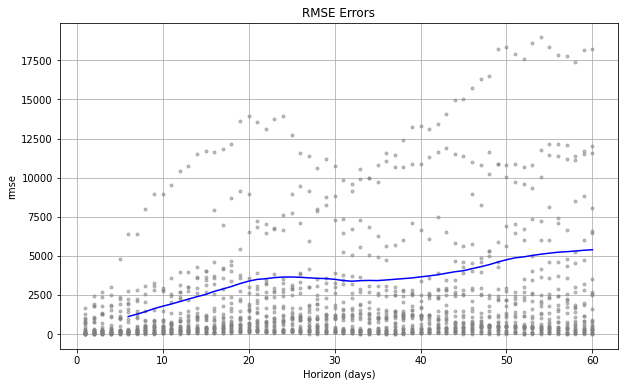

In [34]:
# visualizing performance metrics
from fbprophet.plot import plot_cross_validation_metric
fig5 = plot_cross_validation_metric(df_cv, metric='rmse')
plt.title('RMSE Errors')
plt.show()

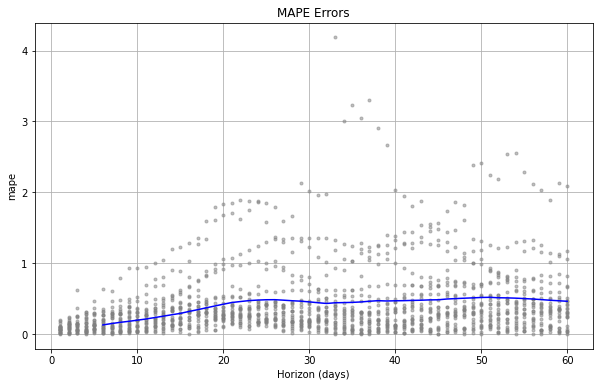

In [35]:
fig6 = plot_cross_validation_metric(df_cv, metric='mape')
plt.title('MAPE Errors')
plt.show()

### 6. Extrapolating Future Stock Data

In practice, it is obvious we really want a forecast model to make a prediction beyond the training data. We will predict future stock prices for the coming 60 days and plot results. The dataframe with forecasted results is attached in the repository.

In [36]:
# forecast 60 days ahead - out-of-sample
out_sample = model.make_future_dataframe(periods=60, freq='D', include_history=True)
forecast = model.predict(out_sample)

In [37]:
# save results to Excel file
forecast.to_excel('results.xlsx', sheet_name='forecast_data', index=False, header=True)

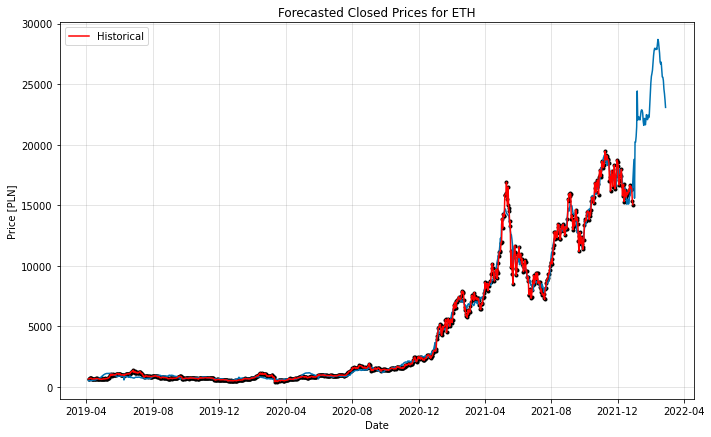

In [38]:
# plot the predicted values
# uncertainty=True - displays confidence interval (blue shadow)
fig7 = model.plot(fcst=forecast, xlabel='Date', ylabel='Price [PLN]', uncertainty=False)
fig8 = plt.plot(df['ds'], df['y'], color='r', label='Historical')
plt.title('Forecasted Closed Prices for {}'.format(symbol))
plt.legend(loc='upper left')
plt.show()

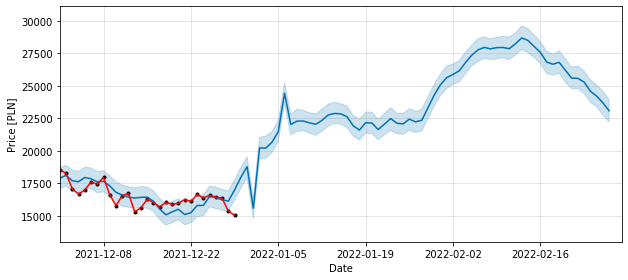

In [39]:
# plot more clearer view
fig9 = model.plot(fcst=forecast, xlabel='Date', ylabel='Price [PLN]', uncertainty=True, figsize=(9,4))
plt.plot(df['ds'], df['y'], color='r')
# x axis date range to plot
fig9.gca().set_xlim(pd.to_datetime(['2021-12-01', '2022-03-01']))
# y axis lower bound
fig9.gca().set_ylim(bottom=13000)
plt.show()

### 7. Summary and Final Thoughts

The object of this project was to predict future stock prices for Ethereum cryptocurrency. The task was done and we successfully built our predictive model. We can clearly see that the <code>Prophet</code> model performed very good and is well suited for time series forecasting.

Indeed, this library is easy to understand, doesn't require much machine learning knowledge, and is almost completely automatic. It is still recommended to implement custom features, like seasonality or special events for better forecasting results. The Facebook model is very flexible, meaning we can customize it at will by adding features and external regressors. It's better to do some extra research about trends and external behaviours that influence stock prices. Sometimes it requires the "trial and error" method and we need to try different options and choose the more accurate one.

Stock price forecasting is an extremely difficult task. Although this model performed well, any stock prediction models out there shouldn't be taken for granted and blindly rely on them. They are used primarily for illustrative purposes and to know what to expect in the near future. However models might be able to predict stock price movement correctly most of the time, but not always.